[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nukaa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nukaa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nukaa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset loaded successfully from C:\Users\nukaa\Downloads\fake_news_dataset.csv
Columns in dataset: ['title', 'text', 'date', 'source', 'author', 'category', 'label']
First few rows of the dataset:
                                   title  \
0               Foreign Democrat final.   
1   To offer down resource great point.   
2          Himself church myself carry.   
3                  You unit its should.   
4  Billion believe employee summer how.   

                                                text        date    source  \
0  more tax development both store agreement lawy...  2023-03-10  NY Times   
1  probably guess western behind likely next inve...  2022-05-25  Fox News   
2  them identify forward present success risk sev...  2022-09-01       CNN   
3  phone which item yard Republican safe where po...  2023-02-07   Reuters   
4  wonder myself fact difficult course forget exa...  2023-04-03       CNN   

                 author    category label  
0          Paula George    Po

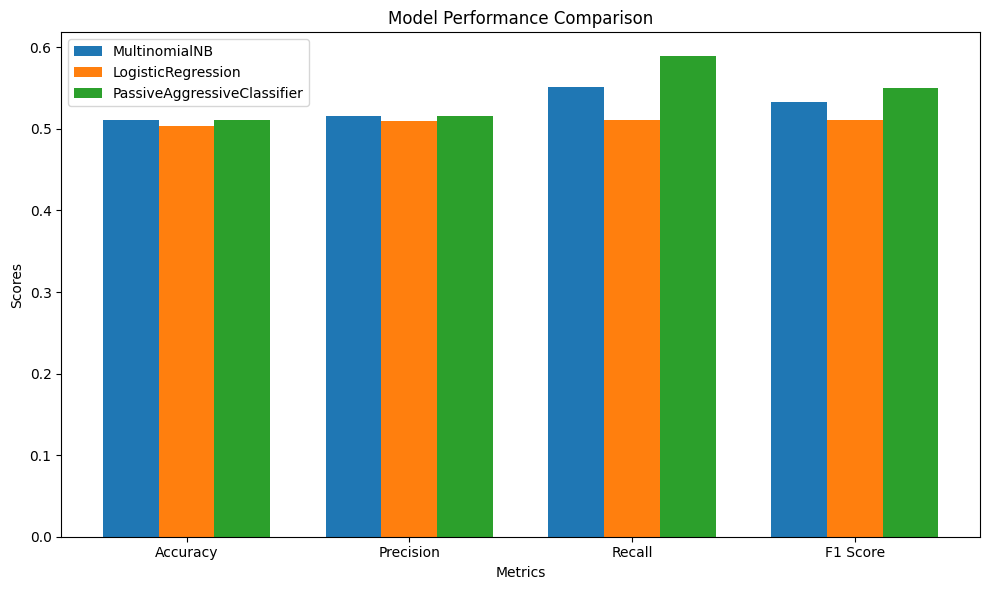

2025-06-20 10:57:46.753 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-20 10:57:47.058 
  command:

    streamlit run C:\Users\nukaa\AppData\Roaming\Python\Python313\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-06-20 10:57:47.058 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-20 10:57:47.059 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-20 10:57:47.059 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-20 10:57:47.060 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-20 10:57:47.060 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-20 10:57:47.061 Thre


Evaluation complete. To run the Streamlit app, save this script as a .py file and run: streamlit run script_name.py


In [1]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import matplotlib.pyplot as plt
import os
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import streamlit as st

title_col = 'title'    # e.g., 'Headline'
author_col = 'author'  # e.g., 'Writer'
text_col = 'text'      # e.g., 'Content'
label_col = 'label'    # e.g., 'IsFake'

possible_paths = [
    r"C:\Users\nukaa\Downloads\fake_news_dataset.csv",
    r"C:\Users\nukaa\Downloads\fake_news_dataset.csv",
    r"C:\Users\nukaa\Downloads\fake_news_dataset.csv"
]

def load_dataset(paths):
    for file_path in paths:
        if os.path.exists(file_path):
            try:
                df = pd.read_csv(file_path)
                print(f"Dataset loaded successfully from {file_path}")
                print("Columns in dataset:", df.columns.tolist())
                print("First few rows of the dataset:\n", df.head())
                return df, file_path
            except pd.errors.EmptyDataError:
                print(f"Error: {file_path} is empty or corrupted.")
                return None, None
    print("Could not find fake_news_dataset.csv in the specified paths.")
    print("Checked paths:", paths)
    downloads_dir = r"C:\Users\nukaa\Downloads"
    if os.path.exists(downloads_dir):
        print("Contents of Downloads folder:", os.listdir(downloads_dir))
    return None, None

def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in string.punctuation and word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

train, loaded_path = load_dataset(possible_paths)

if train is None:
    raise SystemExit("Cannot proceed without the dataset. Please fix the file path and rerun.")

print(f"\nDataset Shape: {train.shape}")
print("\nMissing values in dataset:\n", train.isnull().sum())

train = train.fillna(' ')
print("DataFrame after filling missing values:\n", train.head())

# Convert columns to strings and create 'total'
train[title_col] = train[title_col].astype(str)
train[author_col] = train[author_col].astype(str)
train[text_col] = train[text_col].astype(str)
try:
    train['total'] = train[title_col] + ' ' + train[author_col] + ' ' + train[text_col]
    print("First few entries of 'total' column:\n", train['total'].head())
except KeyError as e:
    print(f"Error: {e}. Please check if columns '{title_col}', '{author_col}', '{text_col}' exist.")
    print("Available columns:", train.columns.tolist())
    raise SystemExit("Cannot proceed without correct column names.")

train['total'] = train['total'].apply(preprocess_text)

try:
    X = train['total']
    y = train[label_col]
except KeyError as e:
    print(f"Error: {e}. Please check if '{label_col}' column exists.")
    print("Available columns:", train.columns.tolist())
    raise SystemExit("Cannot proceed without label column.")

# Standardize labels
print("Unique labels in dataset:", y.unique())
if y.dtype == object:
    if set(y.unique()) == {'real', 'fake'}:
        y = y.map({'real': 0, 'fake': 1})
    else:
        raise ValueError("Unknown string labels. Expected 'real' and 'fake'. Adjust the mapping.")
elif set(y.unique()) == {0, 1}:
    pass
else:
    raise ValueError("Unknown label format. Expected {0,1} or {'real','fake'}.")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer(max_df=0.7)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'PassiveAggressiveClassifier': PassiveAggressiveClassifier(max_iter=1000)
}

results = {}
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_val_tfidf)
    accuracy = metrics.accuracy_score(y_val, y_pred)
    precision = metrics.precision_score(y_val, y_pred, pos_label=1)
    recall = metrics.recall_score(y_val, y_pred, pos_label=1)
    f1 = metrics.f1_score(y_val, y_pred, pos_label=1)
    results[name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
    print(f"\nResults for {name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    cm = metrics.confusion_matrix(y_val, y_pred, labels=[0, 1])
    print(f"Confusion Matrix (0=real, 1=fake):\n{cm}")

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
model_names = list(results.keys())
scores = np.array([[results[model][metric] for metric in metrics_names] for model in model_names])

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metrics_names))
width = 0.25
for i, model in enumerate(model_names):
    ax.bar(x + i * width, scores[i], width, label=model)
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width * (len(model_names) - 1) / 2)
ax.set_xticklabels(metrics_names)
ax.legend()
plt.tight_layout()
plt.show()

st.title("Fake News Detection")
st.write("Enter a news article (title, author, and text) to predict if it's fake or real.")
title_input = st.text_input("Article Title")
author_input = st.text_input("Author")
text_input = st.text_area("Article Text")

if st.button("Predict"):
    if title_input or author_input or text_input:
        input_text = f"{title_input} {author_input} {text_input}"
        input_text = preprocess_text(input_text)
        input_tfidf = tfidf_vectorizer.transform([input_text])
        best_model = PassiveAggressiveClassifier(max_iter=1000)
        best_model.fit(X_train_tfidf, y_train)
        prediction = best_model.predict(input_tfidf)[0]
        st.write("Prediction: **Fake**" if prediction == 1 else "Prediction: **Real**")
    else:
        st.write("Please enter at least one field to make a prediction.")

print("\nEvaluation complete. To run the Streamlit app, save this script as a .py file and run: streamlit run script_name.py")